<a href="https://colab.research.google.com/github/simonaron1111/GA_algoritmusok/blob/main/LAB03_GA_Szelekcios_Modszerek_V1_Boltzman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Genetikus algoritmusok – **Szelekciós módszerek** (HU)

Ebben a jegyzetben a leggyakoribb szelekciós eljárásokat fogjuk gyakorolni:

- **Fitness arányos (rulettkerék)**
- **Tournament szelekció (k-fős verseny)**
- **Rang alapú szelekció**
- **Elitizmus**

Házi feladat extra pontokért:

- **Boltzmann / sztochasztikus szelekció** (Bónusz feladat)
- **Truncation (csonkolás)** (Bónusz feladat)


**Labor célja:** az evolúciós nyomás és diverzitás **egyensúlyának** bemutatása, valamint a módszerek **előnyeinek / hátrányainak** megértése.


In [1]:

import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
random.seed(7)
np.random.seed(7)



## 0) Oktatási minta-populáció

Az alábbi **kis populáció** segít szemléltetni a módszerek viselkedését. A fitness értékeket úgy választjuk, hogy legyenek **extrém különbségek** is (hogy lássuk a torzító hatást).

- Populáció méret: `N = 10`
- Fitness: néhány nagyon jó, több közepes, és 1–2 gyenge egyed


In [2]:

# Minta-populáció (azonosítók és fitness)
N = 10
ids = np.array([f"ind_{i}" for i in range(N)])

# Kézzel beállított, szemléltető fitnessek (extrém különbségekkel)
fitness = np.array([2, 5, 1, 30, 4, 3, 18, 0.5, 8, 0.2], dtype=float)

# Normalizáló segédfüggvények
def normalize_positive(x):
    # Eltolás, hogy minden érték >= 0 legyen
    m = np.min(x)
    if m < 0:
        x = x - m
    return x

def softmax_scaled(x, T=1.0):
    # Boltzmann valószínűségek: exp(x/T) normalizálva (numerikusan stabil)
    z = (x - np.max(x)) / max(T, 1e-8)
    e = np.exp(z)
    return e / np.sum(e)

print("Egyedek:", ids)
print("Fitness :", fitness)


Egyedek: ['ind_0' 'ind_1' 'ind_2' 'ind_3' 'ind_4' 'ind_5' 'ind_6' 'ind_7' 'ind_8'
 'ind_9']
Fitness : [ 2.   5.   1.  30.   4.   3.  18.   0.5  8.   0.2]


In [3]:

def plot_selection_counts(ids, counts, title):
    # Egyszerű oszlopdiagram: kiválasztási gyakoriságok
    plt.figure()
    x = np.arange(len(ids))
    plt.bar(x, counts)
    plt.xticks(x, ids, rotation=45, ha='right')
    plt.ylabel("Kiválasztások száma")
    plt.title(title)
    plt.tight_layout()
    plt.show()



## 1) Fitness arányos szelekció (rulettkerék)

**Ötlet:** az egyed kiválasztási valószínűsége arányos a fitness értékével.  
- **Előny:** egyszerű, intuitív.  
- **Hátrány:** **extrém** fitness különbségeknél **eltorzul**, a legjobb(ak) dominál(nak), **diverzitás csökkenhet**.

> Megjegyzés: negatív fitness esetén eltolást/normalizálást kell alkalmazni.


Rulettkerék valószínűségek (≈):
ind_0: p≈0.028
ind_1: p≈0.070
ind_2: p≈0.014
ind_3: p≈0.418
ind_4: p≈0.056
ind_5: p≈0.042
ind_6: p≈0.251
ind_7: p≈0.007
ind_8: p≈0.112
ind_9: p≈0.003


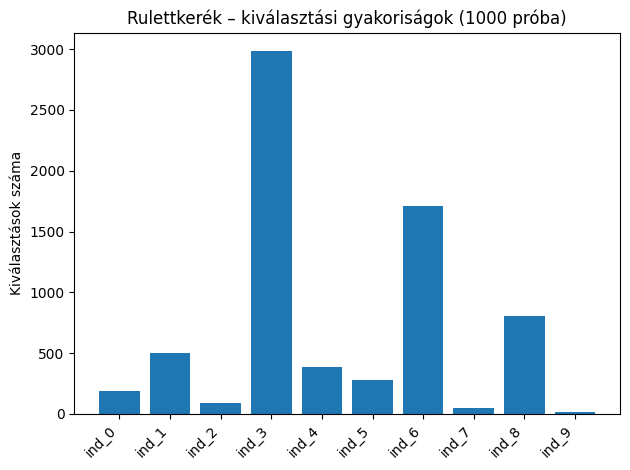

In [4]:

def roulette_wheel_selection(ids, fitness, n_select):
    f = normalize_positive(fitness.astype(float))
    total = np.sum(f)
    if total <= 0:
        # ha minden 0, uniform választás
        p = np.ones_like(f) / len(f)
    else:
        p = f / total
    # mintavétel visszatevéssel
    chosen = np.random.choice(ids, size=n_select, replace=True, p=p)
    return chosen, p

# Illusztráció: ismételt kiválasztások és gyakoriság diagram
n_trials = 7000
selected, probs = roulette_wheel_selection(ids, fitness, n_trials)
unique, counts = np.unique(selected, return_counts=True)

print("Rulettkerék valószínűségek (≈):")
for i, id_ in enumerate(ids):
    print(f"{id_}: p≈{probs[i]:.3f}")

# Grafikon
count_map = {u:c for u,c in zip(unique, counts)}
counts_ordered = np.array([count_map.get(i, 0) for i in ids])
plot_selection_counts(ids, counts_ordered, "Rulettkerék – kiválasztási gyakoriságok (1000 próba)")



## 2) Tournament szelekció (k-fős verseny)

**Ötlet:** minden kiválasztáshoz véletlenszerűen választunk `k` egyedet, és **közülük a legjobb** nyer.  
- **Előny:** **gyors**, **skálázható**, ritkábban zuhan túlzott szelekciós nyomásba.  
- **Paraméter:** a `k` növelése erősíti a szelekciós nyomást (kicsi `k` → több diverzitás).


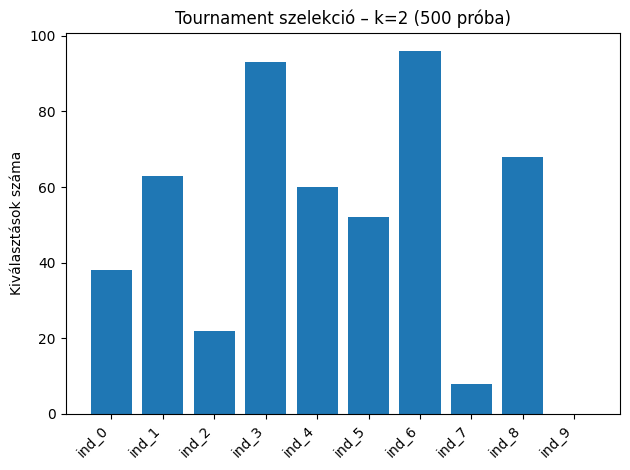

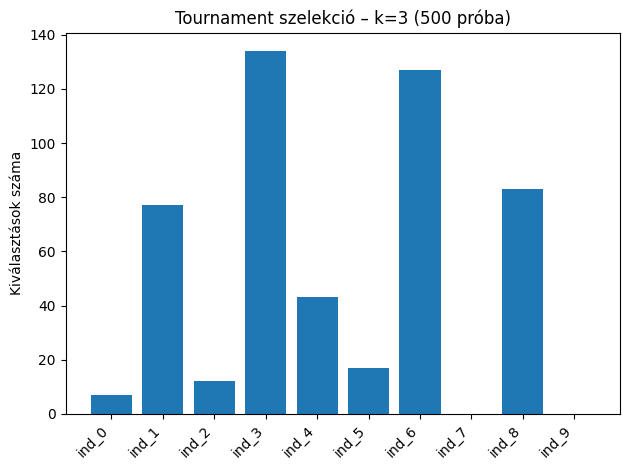

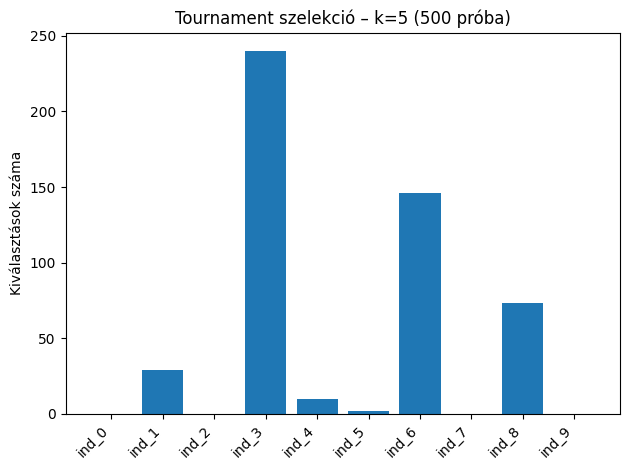

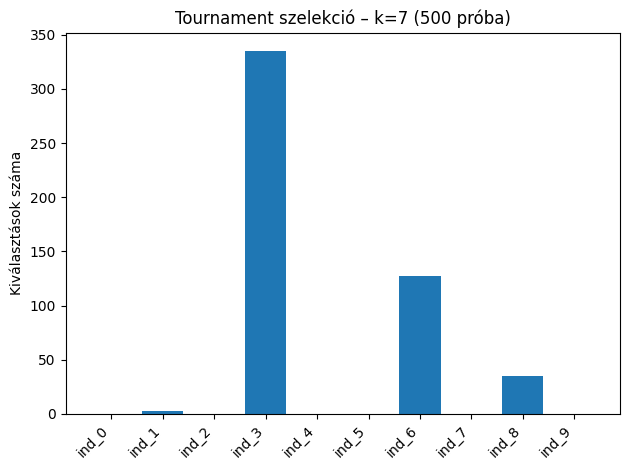

In [ ]:

def tournament_selection(ids, fitness, n_select, k=4):
    chosen = []
    for _ in range(n_select):
        idxs = np.random.choice(len(ids), size=k, replace=False)
        best_idx = idxs[np.argmax(fitness[idxs])]
        chosen.append(ids[best_idx])
    return np.array(chosen)

# Hasonlítsuk össze különböző k értékekkel
for k in [2, 3, 5, 7]:
    n_trials = 500
    sel = tournament_selection(ids, fitness, n_trials, k=k)
    uniq, cnt = np.unique(sel, return_counts=True)
    count_map = {u:c for u,c in zip(uniq, cnt)}
    counts_ordered = np.array([count_map.get(i, 0) for i in ids])
    plot_selection_counts(ids, counts_ordered, f"Tournament szelekció – k={k} (500 próba)")



## 3) Rang alapú szelekció

**Ötlet:** az egyedeket **rangsoroljuk** fitness szerint, és a kiválasztási esély a **ranghoz kötött**.  
- **Előny:** stabilizálja a szelekciót, **ellenálló** extrém fitness különbségeknél is (nem engedi túl-dominálni a csúcs értékeket).  
- **Megvalósítás:** pl. lineáris rangsúlyozás – a legjobb rang kapja a legnagyobb valószínűséget, de arányok kontrolláltak.


Rangsúlyok (legnagyobb a legjobb): [ 4  7  3 10  6  5  9  2  8  1]
Rang alapú valószínűségek (≈): [0.073 0.127 0.055 0.182 0.109 0.091 0.164 0.036 0.145 0.018]


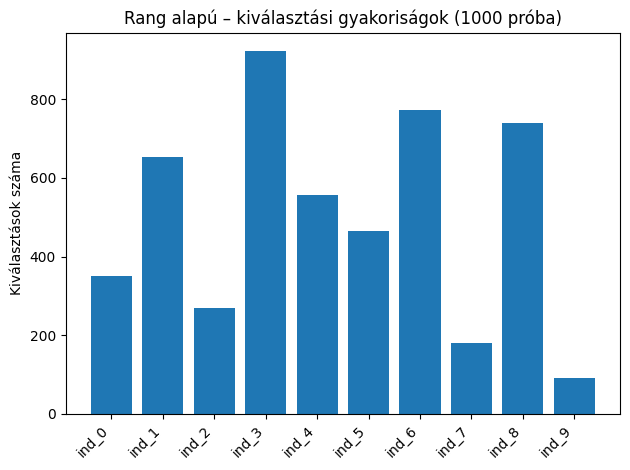

In [22]:

def rank_based_selection(ids, fitness, n_select):
    # Rangsorolás (nagyobb fitness -> jobb rang)
    order = np.argsort(-fitness)  # desc
    ranks = np.empty_like(order)
    ranks[order] = np.arange(len(ids), 0, -1)  # legjobb kapja a legnagyobb rangszámot

    # Lineáris valószínűség a ranghoz arányosan
    p = ranks / np.sum(ranks)
    chosen = np.random.choice(ids, size=n_select, replace=True, p=p)
    return chosen, p, ranks

n_trials = 5000
selected, p_rank, ranks = rank_based_selection(ids, fitness, n_trials)
uniq, cnt = np.unique(selected, return_counts=True)
count_map = {u:c for u,c in zip(uniq, cnt)}
counts_ordered = np.array([count_map.get(i, 0) for i in ids])

print("Rangsúlyok (legnagyobb a legjobb):", ranks)
print("Rang alapú valószínűségek (≈):", np.round(p_rank, 3))
plot_selection_counts(ids, counts_ordered, "Rang alapú – kiválasztási gyakoriságok (1000 próba)")



## 4) Elitizmus

**Ötlet:** a **legjobb** `E` egyed **garantáltan** átkerül a következő generációba.  
- **Előny:** a **legjobb megoldás** nem vész el.  
- **Hátrány:** túl erős elitizmus → **diverzitás csökken**, **lokális optimumhoz ragadhat**.

Az alábbi példa egyetlen generációt illusztrál: először elit másolás, majd a maradék helyek feltöltése (pl. rang alapú szelekcióval).


In [23]:

def elite_preservation(ids, fitness, E=2):
    # top-E indexek
    order = np.argsort(-fitness)
    elites = ids[order[:E]]
    return elites

def next_generation_with_elite(ids, fitness, pop_size=10, E=3):
    elites = elite_preservation(ids, fitness, E=E)
    remaining = pop_size - E
    selected, _, _ = rank_based_selection(ids, fitness, remaining)
    # új generáció (azonosítók szintjén bemutatva)
    new_gen = np.concatenate([elites, selected])
    return new_gen

new_gen = next_generation_with_elite(ids, fitness, pop_size=10, E=2)
print("Elitek:", elite_preservation(ids, fitness, E=2))
print("Új generáció (azonosítók):", new_gen)


Elitek: ['ind_3' 'ind_6']
Új generáció (azonosítók): ['ind_3' 'ind_6' 'ind_3' 'ind_1' 'ind_8' 'ind_8' 'ind_8' 'ind_3' 'ind_8'
 'ind_4']



## 5) Boltzmann / sztochasztikus szelekció

**Ötlet:** valószínűségek **hőmérsékletfüggők** – `p_i ∝ exp(fitness_i / T)`  
- **Magas T:** közel **egyenletes** kiválasztás → **nagy diverzitás**.  
- **Alacsony T:** a nagy fitness **dominál** → **erős nyomás**.

Gyakori stratégia: **hűtés** (T fokozatos csökkentése).



## 6) Truncation (csonkolás) szelekció

**Ötlet:** csak a **legjobb** `p%` kerülhet tovább, a többiek kiesnek.  
- **Előny:** **nagyon erős** szelekciós nyomás, gyors konvergencia.  
- **Hátrány:** **diverzitás** gyors elvesztése, könnyebb **lokális optimum**.

Az alábbi implementáció a top `p%` halmazból választ **visszatevéssel** (ha a populációt ugyanarra a méretre akarjuk feltölteni).



## 7) Kérdések és rövid, gyakorlati válaszok

**Mi a különbség a rulettkerék- és a tournament-szelekció között?**  
- Rulettkerék: valószínűség **arányos** a fitness-szel → **extrém értékek torzíthatnak**.  
- Tournament: mindig **k** jelölt versenyez, a **legjobb nyer** → paraméterezhető nyomás, **skálázható** és robusztusabb extrémekkel szemben.

**Miért előnyös a rang alapú szelekció extrém fitness különbségek esetén?**  
- Mert a kiválasztási esélyt **nem a nyers fitness**, hanem a **rang** határozza meg → **stabilabb**, nem engedi a túl-dominanciát.

**Milyen előnye és hátránya van az elitizmusnak?**  
- Előny: a **legjobb megoldás** nem vész el, **monoton** javulás biztosítható.  
- Hátrány: túl nagy elit arány → **diverzitás** csökken, **beszorulás** lokális optimumba.

**Mely szelekciós módszer illik legjobban a permutációs ábrázoláshoz?**  
- Gyakorlati tapasztalat szerint a **tournament** és **rang alapú** jól működik permutációknál, mert **robosztusabbak** az outlierekkel szemben és jól **skálázódnak**.

**Miért engednek néha a gyengébb egyedeknek is esélyt a szelekcióban?**  
- A **diverzitás** fenntartása miatt: a túl erős nyomás **korai konvergenciához** vezethet. Némi véletlen esély segít elkerülni a **lokális optimumot** és támogatja a **feltárást**.


# Szelekciós módszerekhez gyakorló feladatok
Ez a notebook a szelekciós módszerekhez és deceptív függvényekhez kapcsolódó gyakorlófeladatokat tartalmazza.

## 1. Feladat – Rulettkerék valószínűségek
Számold ki a rulettkerekes kiválasztási valószínűségeket.
Az ids és fitness tömbök alapján:



1.   Számold ki a fitness-ek összegét.
2.   Számold ki minden egyed rulettkerekes kiválasztási valószínűségét:

$$
p_i = \frac{f_i}{\sum_j f_j}
$$


2.   Add meg, melyik egyedé a legnagyobb és a legkisebb valószínűség.

Megjegyzés: elég 3-4 tizedesig kerekíteni.

In [7]:

N = 10
ids = np.array([f"ind_{i}" for i in range(N)])
fitness = np.array([random.randint(0, 50) for i in range(N)], dtype=float)

fit_sum = sum(fitness)
if fit_sum == 0:
  probabilities = [1/N for i in range(N)]
else:
  probabilities = [fit / fit_sum for fit in fitness]
probabilities

[np.float64(0.022727272727272728),
 np.float64(0.24242424242424243),
 np.float64(0.09848484848484848),
 np.float64(0.015151515151515152),
 np.float64(0.03787878787878788),
 np.float64(0.20454545454545456),
 np.float64(0.19696969696969696),
 np.float64(0.030303030303030304),
 np.float64(0.11363636363636363),
 np.float64(0.03787878787878788)]

## 2. Feladat – Tournament szelekció (k=3)
Véletlenszerűen válassz 3 különböző egyedet, indexet 0 és 9 között (pl. 2, 4, 6) a populációból.

1.   Írd fel, mely egyedek kerültek a tournament-be (ind_2, ind_4, ind_6) és mi a fitness-ük.
2.   Döntsd el, ki nyer a tournament-ben (ki kerül kiválasztásra).
3.   Röviden írd le: miért mondjuk, hogy a tournament szelekció „erősebb szelekciós nyomást” tud adni, mint a rulettkerék?

In [17]:
import numpy as np
import random

N = 10
ids = np.array([f"ind_{i}" for i in range(N)])
fitness = np.array([random.randint(0, 50) for i in range(N)], dtype=float)
selected_indices = np.random.choice(N, p=fitness/sum(fitness), size=3, replace=False)

tournament_ids = ids[selected_indices]
tournament_fitness = fitness[selected_indices]

print("Tournament egyedek:", tournament_ids)
print("Tournament fitnessek:", tournament_fitness)

winner_idx = np.argmax(tournament_fitness)
print(f"Nyertes (Winner): {tournament_ids[winner_idx]} with fitness {tournament_fitness[winner_idx]}")

# a tournament szelekcio jobb szelekcios nyomast ad, mivel az utolso t-1 egyeden kivul barkinek lehet eselye gyoztesnek lenni, es igy jobb lesz a diverzitas

Tournament egyedek: ['ind_6' 'ind_3' 'ind_0']
Tournament fitnessek: [39. 29. 42.]
Nyertes (Winner): ind_0 with fitness 42.0


## 3. Feladat – Rang alapú szelekció
Rangsorolás és vizsgálat.


1.   Rendezd a populációt fitnesz szerint csökkenő sorrendbe.
2.   Adj mindenkinek rangot (1 = legjobb, 10 = legrosszabb).
3.   Írd fel a (id, fitness, rang) hármast egy kis táblázatba.
4.   Magyarázd meg 2 mondatban, miért kevésbé érzékeny a rang alapú szelekció az extrém fitness értékekre, mint a rulettkerék.

In [18]:
import numpy as np
import random

N = 10
ids = np.array([f"ind_{i}" for i in range(N)])
fitness = np.array([random.randint(0, 50) for i in range(N)], dtype=float)

sorted_indices = np.argsort(fitness)[::-1]

print(f"{'Rang':<6} | {'ID':<10} | {'Fitness':<8}")
print("-" * 30)

for rank, idx in enumerate(sorted_indices, start=1):
    current_id = ids[idx]
    current_fitness = fitness[idx]

    print(f"{rank:<6} | {current_id:<10} | {current_fitness:<8.1f}")


# a rang alapu szelekcioban nem tudja egy-egy magas fitnessz erteku egyed dominalni a valasztas, mivel a rang egy linearis eselyt biztosit mindenkinek, csak a relaciok fontosak, nem a konkret ertekek

Rang   | ID         | Fitness 
------------------------------
1      | ind_1      | 49.0    
2      | ind_4      | 47.0    
3      | ind_8      | 31.0    
4      | ind_6      | 25.0    
5      | ind_7      | 25.0    
6      | ind_2      | 18.0    
7      | ind_5      | 15.0    
8      | ind_0      | 13.0    
9      | ind_3      | 8.0     
10     | ind_9      | 5.0     


## 4. Feladat (közepes) – Rulettkerék vs Tournament (10 000 futás)
Hasonlítsd össze a gyakoriságokat. Írj egy rövid Python-kódot, amely:

1.   A notebook-ban korábban definiált ids, fitness tömböt használd.
2.   10 000-szer kiválasztunk:
  - (a) rulettkerékkel,
  - (b) 3-fős tournament-tel.
3.   Külön-külön számold ki, hogy hányszor lett kiválasztva minden egyed.
4.   Ábrázold oszlopdiagramon:
 - x tengely: ind_0 … ind_9
 - y tengely: kiválasztási gyakoriság.
5.   Írj 4–5 mondatot arról, miben különbözik a két eloszlás (melyiknél koncentrálódik jobban a tömeg a legjobb egyedekre, mennyire marad „esélye” a gyengébbeknek stb.).


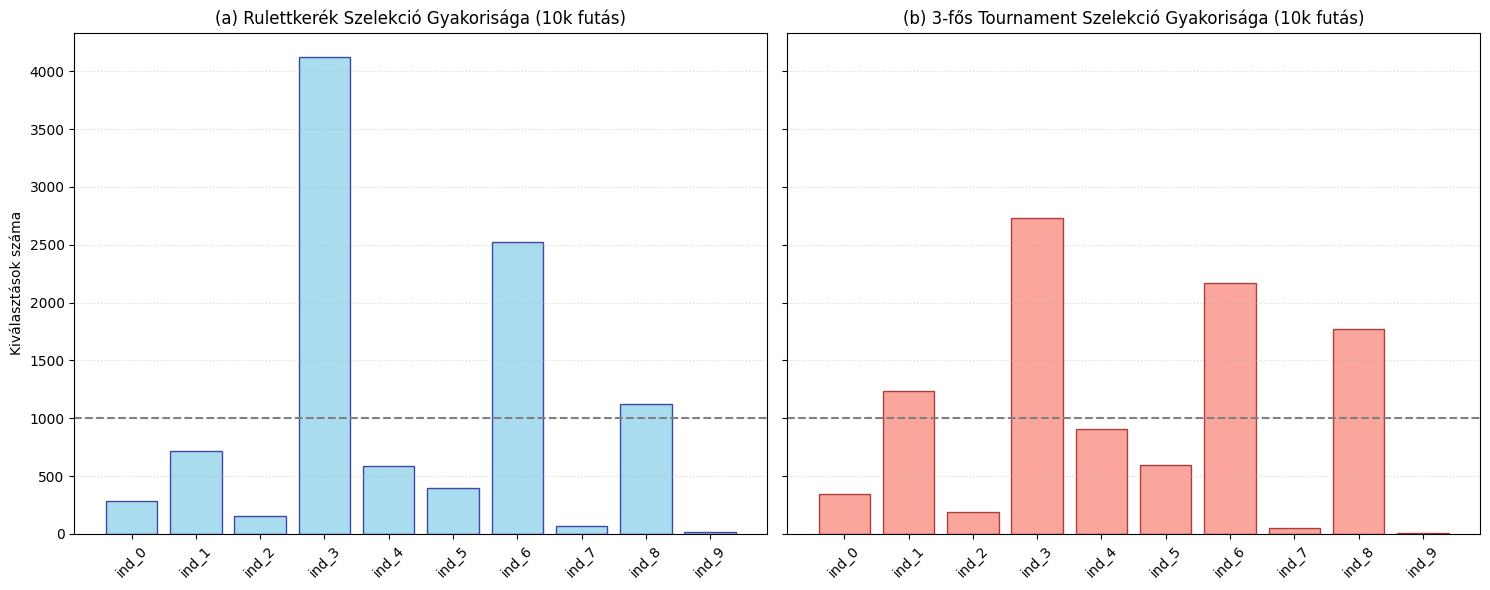

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random

N = 10
ids = np.array([f"ind_{i}" for i in range(N)])
fitness = np.array([2, 5, 1, 30, 4, 3, 18, 0.5, 8, 0.2], dtype=float)

N = len(ids)
SIMULATIONS = 10000

total_fitness = np.sum(fitness)
if total_fitness == 0:
    probs = np.ones(N) / N
else:
    probs = fitness / total_fitness

roulette_selected_indices = np.random.choice(N, size=SIMULATIONS, p=probs, replace=True)

roulette_counts = np.bincount(roulette_selected_indices, minlength=N)


tournament_counts = np.zeros(N, dtype=int)
K = 3

for _ in range(SIMULATIONS):
    candidates_indices = np.random.choice(N, size=K, replace=True)

    candidates_fitness = fitness[candidates_indices]

    winner_local_idx = np.argmax(candidates_fitness)

    winner_global_idx = candidates_indices[winner_local_idx]

    tournament_counts[winner_global_idx] += 1

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

expected_avg = SIMULATIONS / N

axes[0].bar(ids, roulette_counts, color='skyblue', edgecolor='navy', alpha=0.7)
axes[0].axhline(y=expected_avg, color='gray', linestyle='--', label='Átlagos gyakoriság')
axes[0].set_title("(a) Rulettkerék Szelekció Gyakorisága (10k futás)", fontsize=12)
axes[0].set_ylabel("Kiválasztások száma", fontsize=10)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle=':', alpha=0.5)

axes[1].bar(ids, tournament_counts, color='salmon', edgecolor='darkred', alpha=0.7)
axes[1].axhline(y=expected_avg, color='gray', linestyle='--', label='Átlagos gyakoriság')
axes[1].set_title(f"(b) {K}-fős Tournament Szelekció Gyakorisága (10k futás)", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

## 5. Feladat (közepes) – Rang alapú szelekció paraméterérzékenysége

Egészítsd ki a laborkódot úgy, hogy:
1.   Legyen egy függvényed rank_based_selection(ids, fitness, N, s), ahol
- s = szelekciós nyomás (pl. 1.0–2.0 között),
- kiválasztási valószínűségek a rang alapján (pl. Baker-féle lineáris rangszelekció).
2.   Végezz kísérletet 10 000 kiválasztással:
- (a) s = 1.1
- (b) s = 1.9
3.   Hasonlítsd össze a kiválasztási gyakoriságokat: melyik s esetén erősebb a szelekciós nyomás?
4.   Fogalmazz meg 3 következtetést (pl. „nagy s esetén a gyenge egyedek szinte eltűnnek” stb.).

Fitnesz értékek referenciának: [ 2.   5.   1.  30.   4.   3.  18.   0.5  8.   0.2]


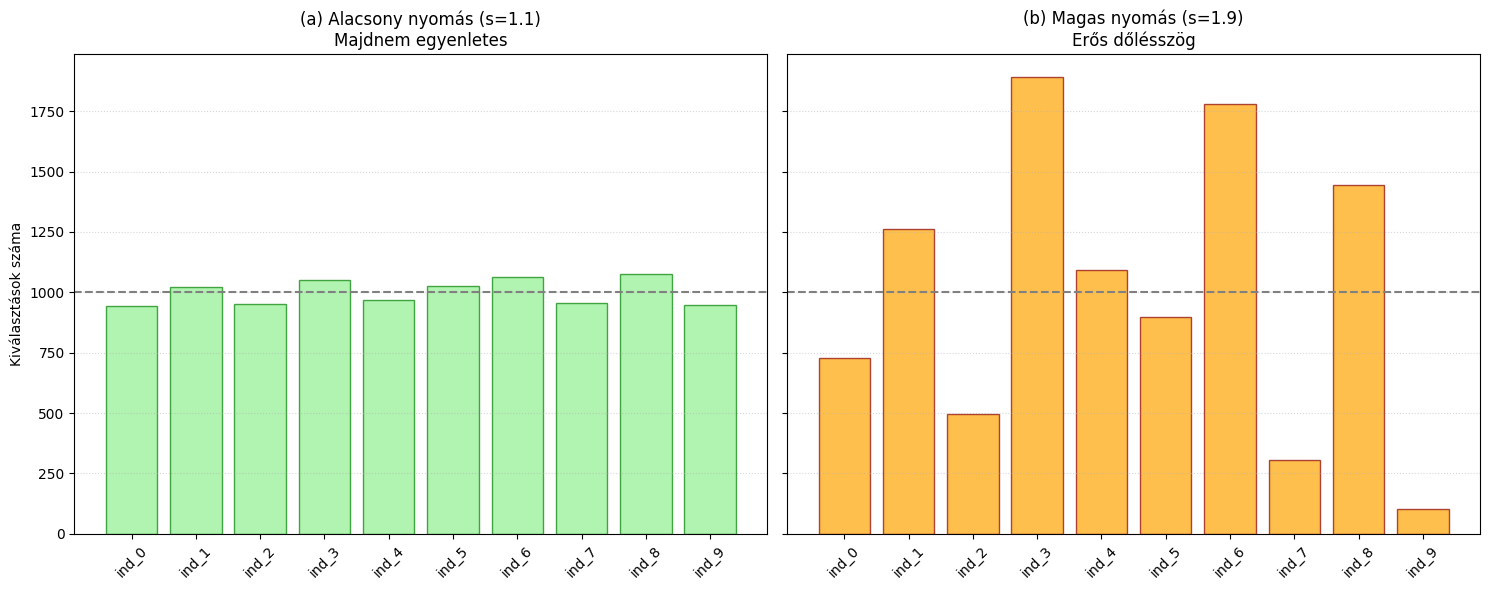

In [20]:
# rank_based_selection implementáció
import numpy as np
import matplotlib.pyplot as plt
import random

def rank_based_selection(ids, fitness, n_sim, s):
    N = len(ids)

    sorted_indices = np.argsort(fitness)[::-1]

    ranks = np.arange(N)
    probs_sorted = (1/N) * (s - (2 * (s - 1) * ranks / (N - 1)))

    probs_sorted /= probs_sorted.sum()

    selected_rank_indices = np.random.choice(N, size=n_sim, p=probs_sorted)

    selected_original_indices = sorted_indices[selected_rank_indices]

    counts = np.bincount(selected_original_indices, minlength=N)

    return counts

SIMULATIONS = 10000

counts_low_s = rank_based_selection(ids, fitness, SIMULATIONS, s=1.1)

counts_high_s = rank_based_selection(ids, fitness, SIMULATIONS, s=1.9)

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
expected_avg = SIMULATIONS / len(ids)

axes[0].bar(ids, counts_low_s, color='lightgreen', edgecolor='green', alpha=0.7)
axes[0].axhline(y=expected_avg, color='gray', linestyle='--', label='Átlag')
axes[0].set_title(f"(a) Alacsony nyomás (s=1.1)\nMajdnem egyenletes", fontsize=12)
axes[0].set_ylabel("Kiválasztások száma")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle=':', alpha=0.5)

axes[1].bar(ids, counts_high_s, color='orange', edgecolor='darkred', alpha=0.7)
axes[1].axhline(y=expected_avg, color='gray', linestyle='--', label='Átlag')
axes[1].set_title(f"(b) Magas nyomás (s=1.9)\nErős dőlésszög", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle=':', alpha=0.5)

plt.tight_layout()
print(f"Fitnesz értékek referenciának: {fitness}")
plt.show()

# az alacsony nyomas szinte eltunteti a rang altali befolyast, tehat egyre inkabb egyenletes eloszlassa valik
# a nagy nyomas meg egyre nagyobb fontossagot ad a magasabb rangu egyedeknek
# minel nagyobb az "s", annal kevesebb eselye van a gyenge, utolso egyedeknek kivalasztodni

## 6. Feladat (közepes) – Elitizmus hatása a diverzitásra
Használd a jegyzetben lévő next_generation_with_elite ötletét:
1.   Készíts egy szimulációt, ahol:
- Populációméret = 10
- Elit méret E = 0, E = 2, E = 5
- Új generáció többi részét mondjuk rang alapú szelekcióval töltöd fel.
2.   Egy egyszerű GA-keretben (pl. 20 generáció, csak szelekció + „dummy” fitness frissítés nélkül) nézd meg:
- Hány különböző egyed marad a populációban (diverzitás) az idő előrehaladtával?
3.   Írj 5–6 mondatot arról, hogyan hat az elitizmus mértéke a diverzitásra és a „beszorulás” kockázatára.

['ind_0' 'ind_1' 'ind_2' 'ind_3' 'ind_4' 'ind_5' 'ind_6' 'ind_7' 'ind_8'
 'ind_9']
[ 2.   5.   1.  30.   4.   3.  18.   0.5  8.   0.2]


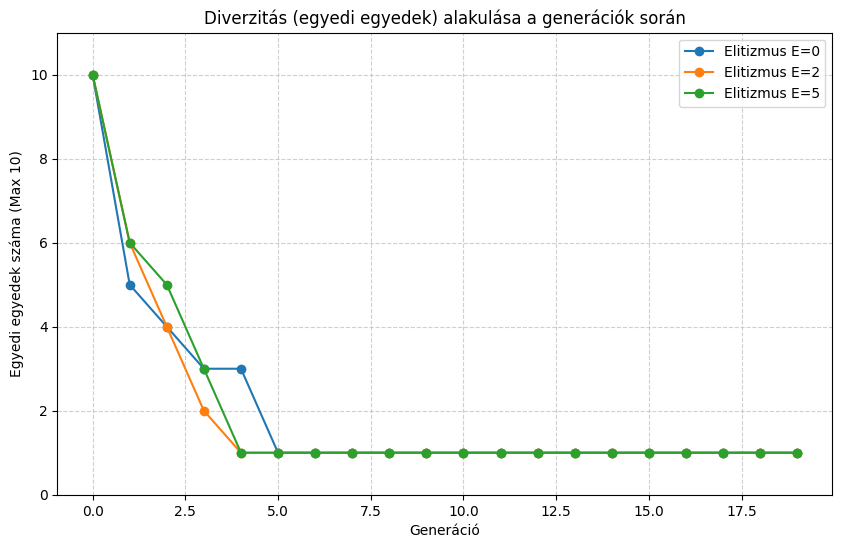

In [32]:
# Diverzitás mérése és grafikon
import numpy as np
import matplotlib.pyplot as plt
import random

fitness_map = dict(zip(ids, fitness))
generations = 20
elitism_levels = [0, 2, 5]
results = {}

for E in elitism_levels:
    current_pop = ids.copy()
    diversity_history = []

    for _ in range(generations):
        current_fitness = np.array([fitness_map[uid] for uid in current_pop])

        diversity_history.append(len(np.unique(current_pop)))

        current_pop = next_generation_with_elite(current_pop, current_fitness, pop_size=N, E=E)

    results[E] = diversity_history


plt.figure(figsize=(10, 6))
for E, history in results.items():
    plt.plot(history, marker='o', label=f'Elitizmus E={E}')

plt.title("Diverzitás (egyedi egyedek) alakulása a generációk során")
plt.xlabel("Generáció")
plt.ylabel("Egyedi egyedek száma (Max 10)")
plt.ylim(0, 11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# a magas elitizmus gyorsan diverzitas zuhanast jelent, mivel a kimaradt egyedek egyre biztosabban klonjai lesznek valamelyiknek az elitek kozul
# az N=10 peldara nehezen latszik a hatasa az elitizmusnak, mert kicsi a peldanyszam, de
# E=5 elitizmusnal altalaban a leggyorsabb a beszukules, mivel a fele populacio elitkent lesz kivalasztva
# az E=2 elitizmus egy mersekeltebb kivalasztodas, lassabban valosul meg a beszukules
# az E=0 tehat semmilyen elitizmus a legkevesbe hajlamos / leglassabban beszukulo, viszont elvesztodik az elitizmus pozitiv hatasa

## 7. Feladat (nehéz) – Boltzmann-szelekció és hőmérséklet ütemezés
Készíts egy saját Boltzmann-szelekció modult, a jegyzetben lévő softmax_scaled függvényt felhasználva:

1.   Definiálj hőmérséklet-idő függvényt:
- (a) Lassú hűtés: T(t) = 5 / (1 + 0.05 * t)
- (b) Gyors hűtés: T(t) = 5 / (1 + 0.5 * t),
- ahol t a generáció sorszáma (0…50).
2.   Egy egyszerű GA-keretben, fix fitness-szel (a laborminta-populáció), 50 generáción át:
- minden generációban számold ki a Boltzmann-alapú kiválasztási valószínűségeket az aktuális T(t) mellett,
- végezz 10 kiválasztást (új populáció).
3.   Mérd minden generációnál:
- a legjobb egyed várható fitnessét (pl. populációmax),
- és a diverzitást (különböző egyedek száma, vagy Shannon-entrópia a gyakoriságokból).
4.   Hasonlítsd össze a lassú és gyors hűtést:
- Melyik esetben „hűl be” gyorsabban a rendszer (csökken a diverzitás)?
- Melyik esetben jobb a végső (50. generációs) legjobb fitness?
5.   Fogalmazz meg rövid szakmai következtetést: mikor lehet hasznos a Boltzmann-szelekció, és hogyan kell óvatosan megválasztani a hőmérséklet ütemezést?

## Softmax / Boltzmann-szelekció

A szelekciós valószínűség képlete blokkos formában:

$$
p_i = \frac{\exp\left(\frac{f_i}{T}\right)}{\sum_{j} \exp\left(\frac{f_j}{T}\right)}
$$

A hőmérséklet időbeli csökkenésének (annealing) tipikus ütemezései:

### Inverz hűtés:
$$
T(t) = \frac{T_0}{1 + \alpha t}
$$

### Exponenciális hűtés:
$$
T(t) = T_0 \cdot \beta^{t}
$$


Kis segítség ....
```
function boltzmann_selection(fitness, T):
    for each f_i in fitness:
        w_i = exp(f_i / T)
    total = sum(w_i)
    p_i = w_i / total
    return p_i

```


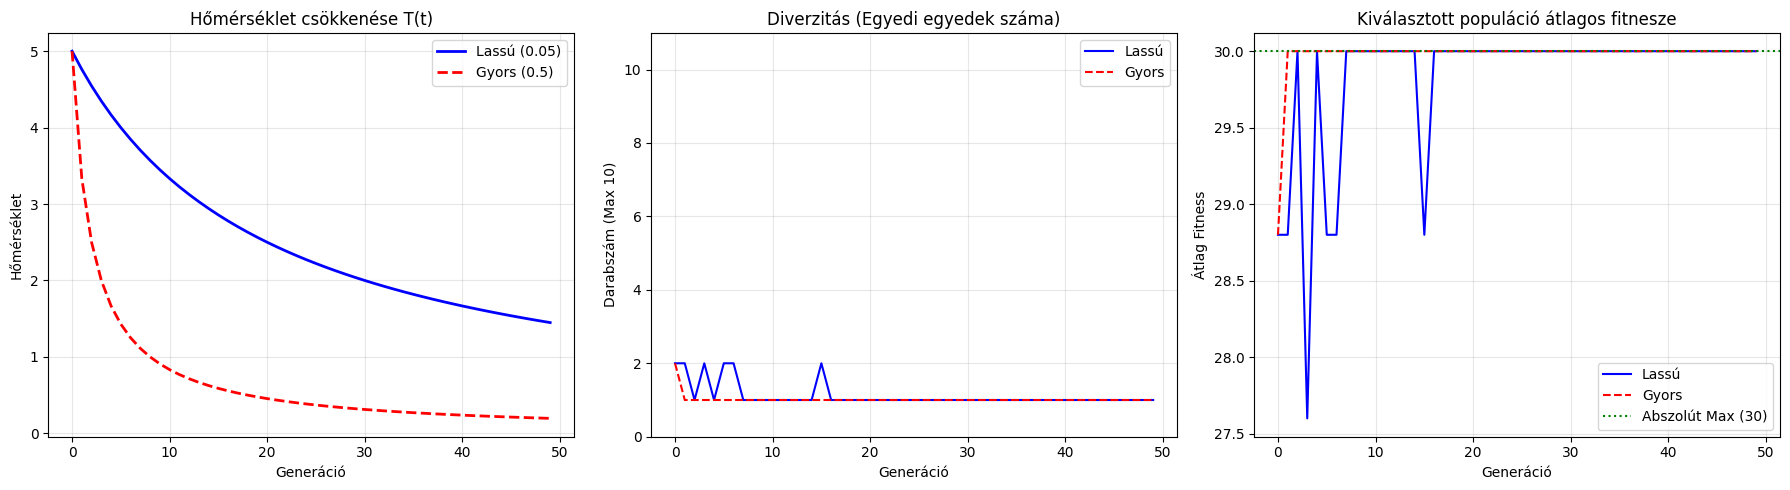

In [33]:
# Boltzmann-szelekció implementáció
import math
import numpy as np
import matplotlib.pyplot as plt
import random

def boltzmann_selection(fitness, T):
    T = max(T, 1e-8)

    shift = np.max(fitness)

    w = np.exp((fitness - shift) / T)

    total = np.sum(w)
    p = w / total

    return p

def get_temperature(t, mode):
    if mode == 'slow':
        return 5 / (1 + 0.05 * t)
    elif mode == 'fast':
        return 5 / (1 + 0.5 * t)
    return 5.0

generations = 50
modes = ['slow', 'fast']
results = {}

for mode in modes:
    div_log = []
    best_fit_log = []
    temp_log = []

    np.random.seed(42)

    for t in range(generations):
        T = get_temperature(t, mode)
        temp_log.append(T)

        probs = boltzmann_selection(fitness, T)

        selected_indices = np.random.choice(np.arange(N), size=10, p=probs, replace=True)

        diversity = len(np.unique(selected_indices))
        div_log.append(diversity)

        avg_fitness = np.mean(fitness[selected_indices])
        best_fit_log.append(avg_fitness)

    results[mode] = {
        'diversity': div_log,
        'fitness': best_fit_log,
        'temp': temp_log
    }

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(results['slow']['temp'], label='Lassú (0.05)', color='blue', linewidth=2)
axes[0].plot(results['fast']['temp'], label='Gyors (0.5)', color='red', linestyle='--', linewidth=2)
axes[0].set_title("Hőmérséklet csökkenése T(t)")
axes[0].set_ylabel("Hőmérséklet")
axes[0].set_xlabel("Generáció")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(results['slow']['diversity'], label='Lassú', color='blue')
axes[1].plot(results['fast']['diversity'], label='Gyors', color='red', linestyle='--')
axes[1].set_title("Diverzitás (Egyedi egyedek száma)")
axes[1].set_ylabel("Darabszám (Max 10)")
axes[1].set_xlabel("Generáció")
axes[1].set_ylim(0, 11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(results['slow']['fitness'], label='Lassú', color='blue')
axes[2].plot(results['fast']['fitness'], label='Gyors', color='red', linestyle='--')
axes[2].axhline(y=30, color='green', linestyle=':', label='Abszolút Max (30)')
axes[2].set_title("Kiválasztott populáció átlagos fitnesze")
axes[2].set_ylabel("Átlag Fitness")
axes[2].set_xlabel("Generáció")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()